# ALD - TME 13: Physics-Informed Neural Networks (PINNs)


In [23]:
import torch
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from contextlib import contextmanager
from pathlib import Path
import subprocess
from functools import partial


# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

np.random.seed(1234)

In [24]:
torch.cuda.is_available()

True


## As a case study, we will apply PINNs on the Burgers equations, following this PDE:

[From Wikipedia](https://en.wikipedia.org/wiki/Burgers%27_equation)

> Burgers' equation or Bateman-Burgers equation is a fundamental partial differential equation and convection-diffusion equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948.

The equation is as follows

$$\frac{\partial u(x,t)}{\partial t} + a ~ u(x,t)  ~ \frac{\partial u(x,t)}{\partial x} - \nu  ~  \frac{\partial^2 u(x,t)}{\partial x^2} =0$$
where $u(x,t)$ is the field (e.g. speed of the fluid at the location $x$ and time $t$).
We will get the solution of this PDE with  the friction coefficient setup to $\nu=\frac{0.01}{\pi}$, and $a=1.0$

**In PINNs, wa want to train a parametric data-driven model $f_{\theta}(x,t)$ to approximate $u(x,t)$ at any (x,t) position.**

# Loading the data

In [25]:
if not Path("burgers_shock.mat").is_file():
    subprocess.run(
        ["wget", "https://thome.isir.upmc.fr/classes/RLD/PINNs/data/burgers_shock.mat"]
    )


data = scipy.io.loadmat("./burgers_shock.mat")

t = torch.Tensor(data["t"].flatten())
x = torch.Tensor(data["x"].flatten())
Exact = torch.Tensor(data["usol"]).T
extent = [t.min(), t.max(), x.min(), x.max()]

print(f"t: {t.shape}")
print(f"x: {x.shape}")
print(f"Exact: {Exact.shape}")

t: torch.Size([100])
x: torch.Size([256])
Exact: torch.Size([100, 256])


In [26]:
print(data["usol"].shape)

(256, 100)


## **Plot the evolution of the solution u(x,t) over time.**

In the figure below, we plot the evolution of $u$ (given in `Exact`) over time (given in `t`, x-axis) and $x$ (given in `x`, y-axis).

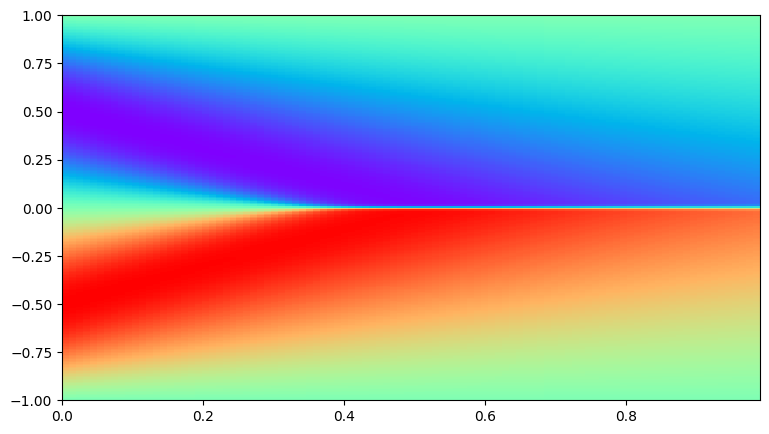

In [27]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)


# Exercice 1: learning the solution with physics-informed constraints

In PINNs, we want to train a parametric data-driven model $f_{\theta}(x,t)$ to approximate $u(x,t)$ at any (x,t) position. PINNs combine two losses during training:

## Supervised loss

A supervised loss, where we have $N_u$ labeled points $\left\{(x_i,t_i,u_i)\right\}_{i \in \left\{ 1 ; N \right\}}$. We use the standard MSE loss between the model prediction $f_{\theta}(x_i,t_i)$ and the ground truth $u_i$:
$$l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$$
In the first exercice, we randomly sample $N_u=100$ points **in the boundary layer** - $(x_{min},t)$, $(x_{max},t)$ and in initial condtions $(x,0)$.

## Unsupervised loss

For the unsupervised loss, we randomly sample $N_f$ points in the $(x,t)$ interval, and enforce the learned function $f_{\theta}$ to fulfill the PDE. Let us define
$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$
We can define the following unsupervised loss
$$l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $$

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$

## **1.1) Collect labeled data and unlabeled physics-informed constraint data.**

In the code below, you will collect $N_u$ supervised data points and $N_f$ unsupervised ones. It should set the following values:

- `X_u_train` is a matrix $N_u \times 2$ (dimensions = $x$ and $t$)
- `u_train` is a vector with $u(x,t)$ values for $(x,t)$ couples in `X_u_train`
- `X_f_train` is a matrix $N_f \times 2$ (dimensions = $x$ and $t$)

In [28]:
# Creates a grid from x and t, of shape (time x position)
T, X = torch.meshgrid(t, x)

assert len(X) == len(t)
assert Exact.shape == T.shape, f"{Exact.shape} vs {T.shape}"

# Shape (N, 2)
X_star = torch.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))

# u(x,t) for X_star
u_star = Exact.flatten()

In [29]:
# Labeled points

N_u = 100  # Number of points to compute the prediction loss (MSE_u)

# À compléter...

x_train = torch.zeros(N_u, 1)
t_train = torch.zeros(N_u, 1)
u_train = torch.zeros(N_u, 1)

print(u_train.shape)

available_t_xmin = torch.arange(t.size(0) - 1)
available_t_xmax = torch.arange(t.size(0) - 1)
available_x_t0 = torch.arange(x.size(0) - 1)
choices = torch.linspace(start=0, end=2, steps=3, dtype=torch.int)

for i in range(N_u):
    choice = np.random.permutation(choices)[0]
    if choice == 0:
        # case (xmin,t)
        x_train[i] = x[0]
        choice_t_xmin = np.random.choice(available_t_xmin)
        np.delete(available_t_xmin, choice_t_xmin)
        t_train[i] = t[choice_t_xmin]
        u_train[i] = Exact[choice_t_xmin, 0]
    elif choice == 1:
        x_train[i] = x[-1]
        choice_t_xmax = np.random.choice(available_t_xmax)
        np.delete(available_t_xmax, choice_t_xmax)
        t_train[i] = t[choice_t_xmax]
        u_train[i] = Exact[choice_t_xmax, -1]
    else:
        # case (x,0)
        t_train[i] = t[0]
        choice_x_t0 = np.random.choice(available_x_t0)
        np.delete(available_x_t0, choice_x_t0)
        x_train[i] = x[choice_x_t0]
        u_train[i] = Exact[0, choice_x_t0]


# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(x.min())) | (x_train == float(x.max()))
).all(), "Some points do not belong to boundary"

torch.Size([100, 1])


In [30]:
# Unlabeled points

N_f = 10000  # Number of points to apply the constraint

# À compléter...
t_idx = torch.arange(t.size(0) - 1)
x_idx = torch.arange(x.size(0) - 1)
x_train_f = x[np.random.choice(x_idx, N_f)].unsqueeze(-1)
t_train_f = t[np.random.choice(t_idx, N_f)].unsqueeze(-1)


# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= x.min()) & (x_train_f <= x.max())).all()
assert ((t_train_f >= t.min()) & (t_train_f <= t.max())).all()

# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

In [31]:
# Let's move everything to the target device


def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

## 1.2) Plot the selected labeled boundary and initial points.

We can now plot the selected points

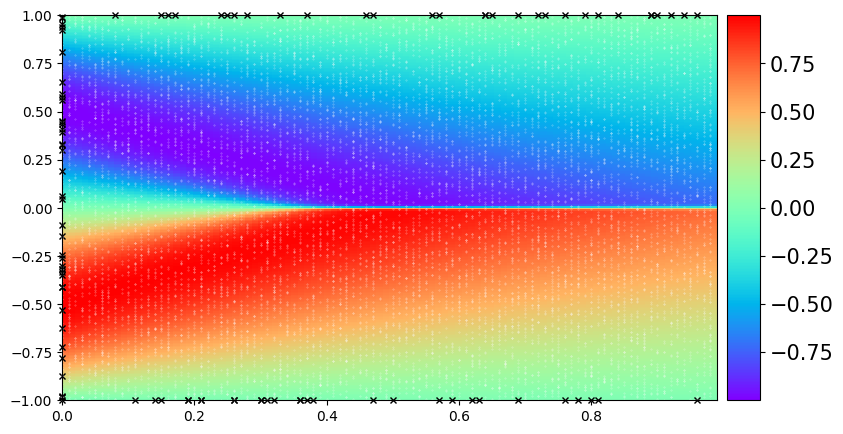

In [32]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

# h = ax.imshow(Exact.T, cmap='rainbow', origin='lower', aspect='auto') # Exact.T size (256,100), u(x,t) avec x[0] = -1
# plt.imshow(Exact.T[::-1,:], cmap='rainbow') # Pour avoir x = -1 en bas

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=1,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

## 1.3) Write the code of for $f_\theta$

We will use a simple fully connected neural network (NN) as $f_{\theta}$.
Use *e.g.* 8 hidden layers with tanh activation functions.



In [33]:
class DNN(torch.nn.Module):
    # À compléter...
    def __init__(self, depth=8, input_size=2, hidden_size=20, output_size=1):
        """
        input of size N_u x 2  = N_u x (x,t) dimensions
        """
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        layers = [("input", nn.Linear(input_size, hidden_size))]

        layers.append(("activation input", nn.Tanh()))
        for i in range(depth):
            layers.append(("hidden %d" % i, nn.Linear(hidden_size, hidden_size)))
            layers.append(("activation %d" % i, nn.Tanh()))
        layers.append(("output", nn.Linear(hidden_size, output_size)))

        dictLayers = OrderedDict(layers)
        self.seq = nn.Sequential(dictLayers)

    def forward(self, x, t):
        X_u_train = torch.cat((x, t), dim=-1)
        return self.seq(X_u_train)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u


dnn = DNN()


dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [34]:
print(dnn)

DNN(
  (seq): Sequential(
    (input): Linear(in_features=2, out_features=20, bias=True)
    (activation input): Tanh()
    (hidden 0): Linear(in_features=20, out_features=20, bias=True)
    (activation 0): Tanh()
    (hidden 1): Linear(in_features=20, out_features=20, bias=True)
    (activation 1): Tanh()
    (hidden 2): Linear(in_features=20, out_features=20, bias=True)
    (activation 2): Tanh()
    (hidden 3): Linear(in_features=20, out_features=20, bias=True)
    (activation 3): Tanh()
    (hidden 4): Linear(in_features=20, out_features=20, bias=True)
    (activation 4): Tanh()
    (hidden 5): Linear(in_features=20, out_features=20, bias=True)
    (activation 5): Tanh()
    (hidden 6): Linear(in_features=20, out_features=20, bias=True)
    (activation 6): Tanh()
    (hidden 7): Linear(in_features=20, out_features=20, bias=True)
    (activation 7): Tanh()
    (output): Linear(in_features=20, out_features=1, bias=True)
  )
)



## 1.4) Write the code of the PhysicsInformedNN.

We will now implement the core class of this practical: the `PhysicsInformedNN`.

It will be predict the fonction $f_{\theta}(x,t)$, and the $h(f_{\theta}(x,t))$, where the latter is defined as:

$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$

Note that you need to use [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to compute derivatives and second order derivatives.

The `forward` function will return both $f_{\theta}(x,t)$ and $h(f_{\theta}(x,t))$.


In [35]:
# the physics-guided neural network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, dnn: DNN, nu: float):
        super().__init__()

        # nu = viscosity
        self.nu = nu
        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x.requires_grad_(True)
        t.requires_grad_(True)

        f_theta = self.dnn(x, t)

        df_dx = torch.autograd.grad(
            f_theta, x, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]
        df_dt = torch.autograd.grad(
            f_theta, t, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]
        df2_dx2 = torch.autograd.grad(
            df_dx, x, torch.ones_like(df_dx), retain_graph=True, create_graph=True
        )[0]

        h_res = df_dt + f_theta * df_dx - self.nu * df2_dx2
        return f_theta, h_res

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


model = PhysicsInformedNN(dnn, 0.01 / np.pi).to(device)

u, f = model(x_train[:5], t_train[:5])
assert u.shape == (5, 1) and f.shape == (5, 1)

## 1.5) Write the code of the pinns_loss to train the PhysicsInformedNN

The `pinss_loss` function should return

- The global loss $\lambda_u l_u + \lambda_f l_f$
- The supervised loss $l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$
- The unsupervised loss $l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$


In [36]:
import torch.nn.functional as F

In [37]:
def pinns_loss(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    f_pred: torch.Tensor,
    lambda_u=1.0,
    lambda_f=1.0,
):
    # À compléter...
    loss_u = F.mse_loss(u_pred, u_target)

    f_target = torch.zeros(f_pred.shape).to(device)
    loss_f = F.mse_loss(f_pred, f_target)

    loss = lambda_u * loss_u + lambda_f * loss_f

    return loss, loss_u, loss_f

## **1.6) Train the model!**

You can use a standard Adam optimizer, or to speed-up convergence a LBFGS. In case of LBFGS, you need to use a closure when calling the step method. This closure will do the forward, and optionally the backward pass:

```python
def loss_closure():
  if torch.is_grad_enabled():
    optimizer.zero_grad()

  loss = ...

  if loss.requires_grad:
    loss.backward()

  return loss

optimizer.step(loss_closure)
```

This closure can be used also when using `Adam` or any other optimizer.


In [38]:
from tqdm import tqdm

In [39]:
# À compléter...
nu = 0.01 / np.pi
a = 1
dnn = DNN()
dnn.to(device)
model = PhysicsInformedNN(dnn, nu)
model.to(device)
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.65)
# optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.01)

epoch = 50
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        u_pred = dnn(x_train, t_train)

        f_theta, f_pred = model(x_train_f, t_train_f)
        loss, loss_u, loss_f = pinns_loss(u_pred, u_train, f_pred)
        ti.set_description(f"loss: {loss}")

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)

loss: 0.21032264828681946:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.0008445063722319901: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


## **1.7) Asses the performances of the model!**

- Visually assess the prediction on the  $(x,t)$ plane
- Compute the mean prediction error, and the error in the $(x,t)$ plane
- the prediction error over time slices at $t=0$, $t=25$, $t=50$, $t=75$

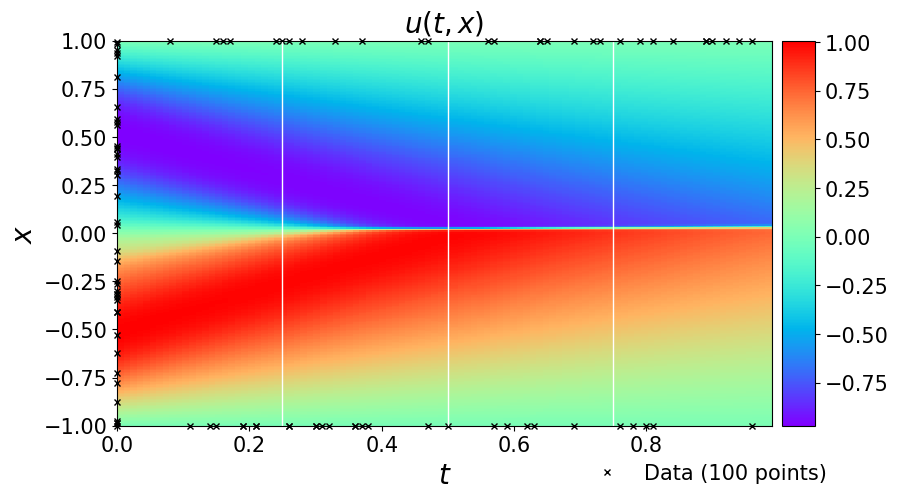

In [40]:
# Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 2.319370e-01


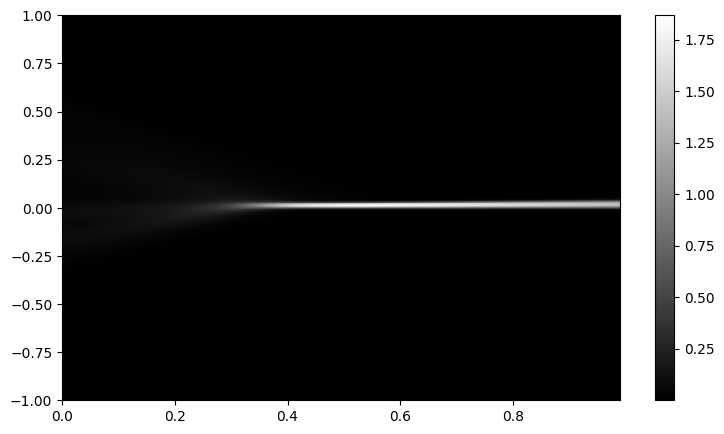

In [41]:
# Compute the mean prediction error
error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

# Error in the $(x,t)$ planefig = plt.figure(figsize=(9, 5))
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(Error.T, extent=extent, origin="lower", aspect="auto", cmap="gray")
cbar = fig.colorbar(h)
plt.show()

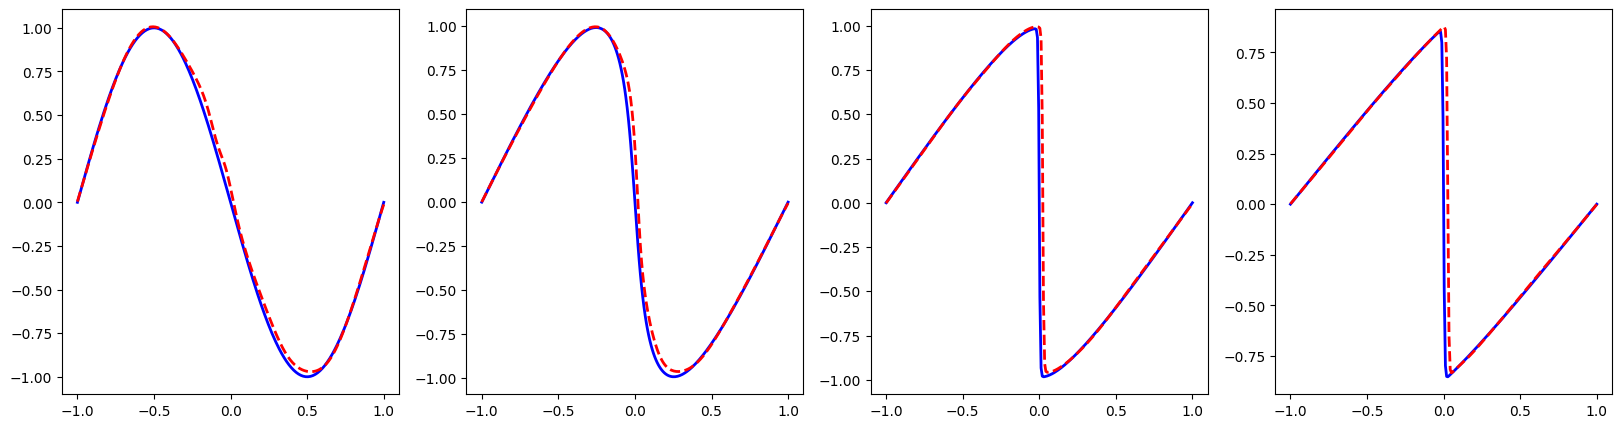

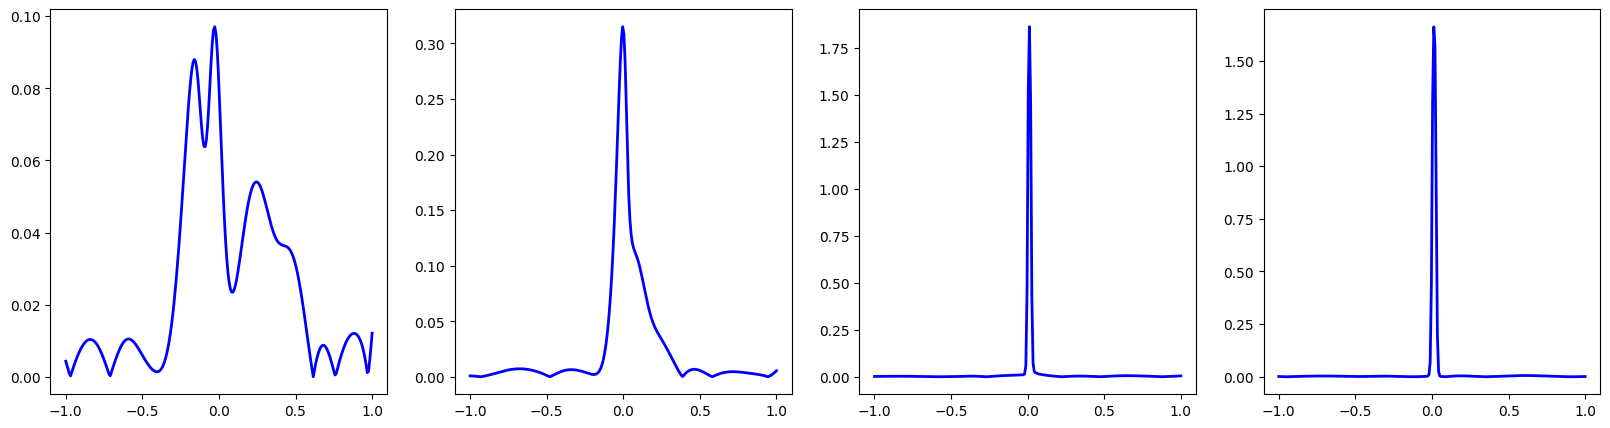

In [42]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

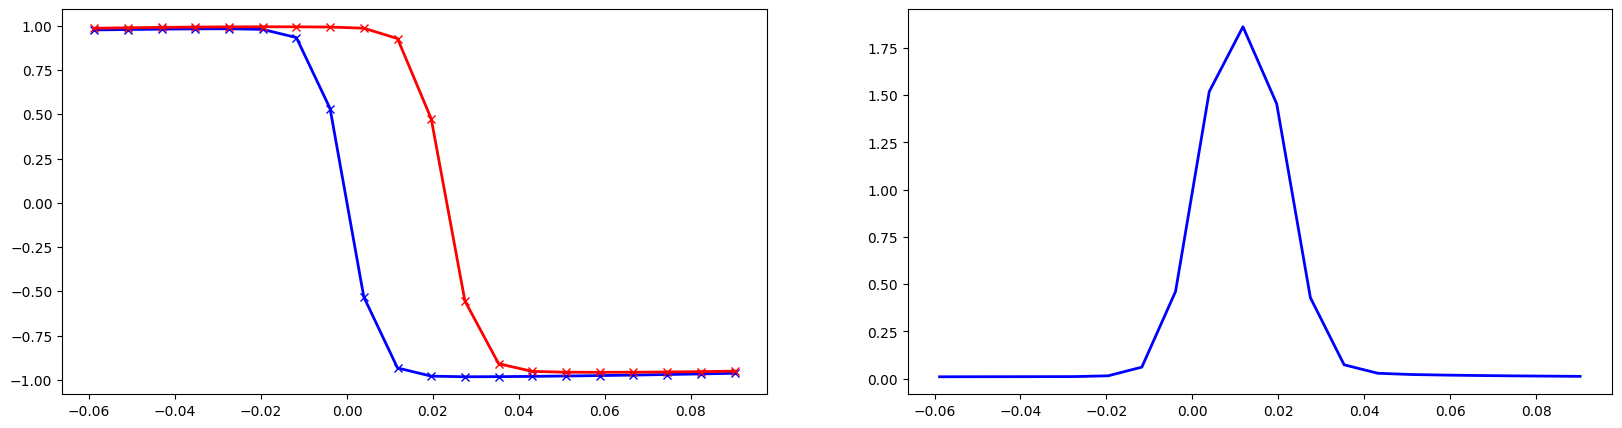

In [43]:
# Close-up on slide at t=50
index = 50
min = 120
max = 140
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot(x[min:max], Exact[index, min:max], "b-x", linewidth=2, label="Exact")
ax.plot(x[min:max], U_pred[index, min:max], "r-x", linewidth=2, label="Prediction")

ax = fig.add_subplot(122)
ax.plot(x[min:max], Error[index, min:max], "b-", linewidth=2, label="Exact")

## **1.8) Train a prediction model without adding any constraint (fully data-driven model). Conclude.**

In [46]:
# À compléter...

nu = 0.01 / np.pi
a = 1
model = DNN()
model.to(device)
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.65)

epoch = 500
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        u_pred = model(x_train, t_train)
        loss = F.mse_loss(u_pred, u_train)
        ti.set_description(f"loss: {loss}")

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)

loss: 0.2103785276412964:   0%|          | 0/500 [00:00<?, ?it/s] 

loss: 3.057804406125797e-06: 100%|██████████| 500/500 [00:07<00:00, 63.48it/s]


Error u: 8.462580e-01


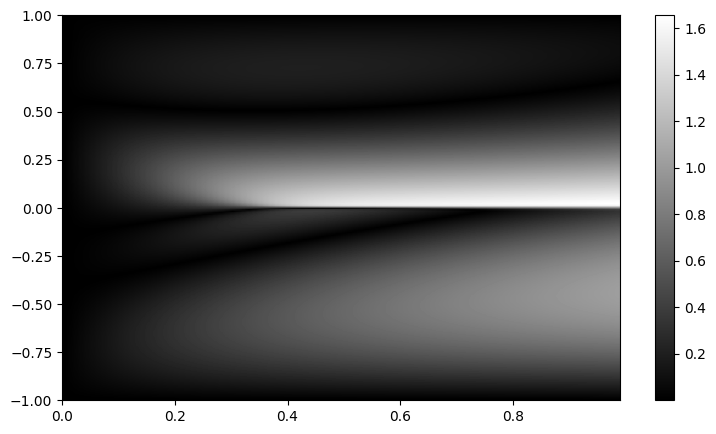

In [47]:
# Compute the mean prediction error
u_pred = model.predict(x_star, t_star)

error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")
Error = np.abs(Exact - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

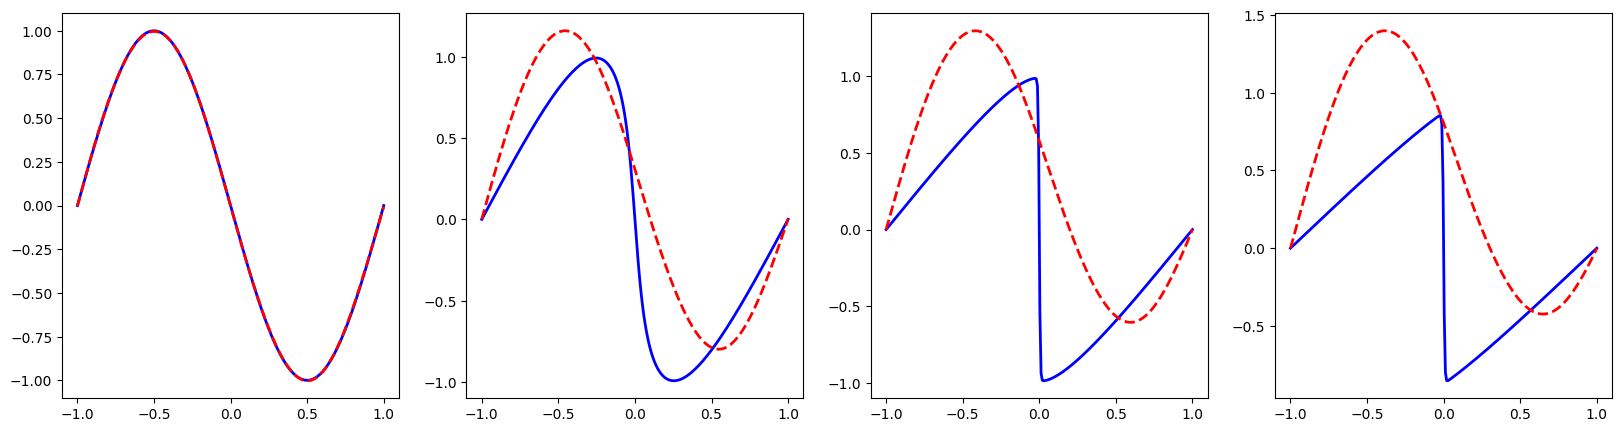

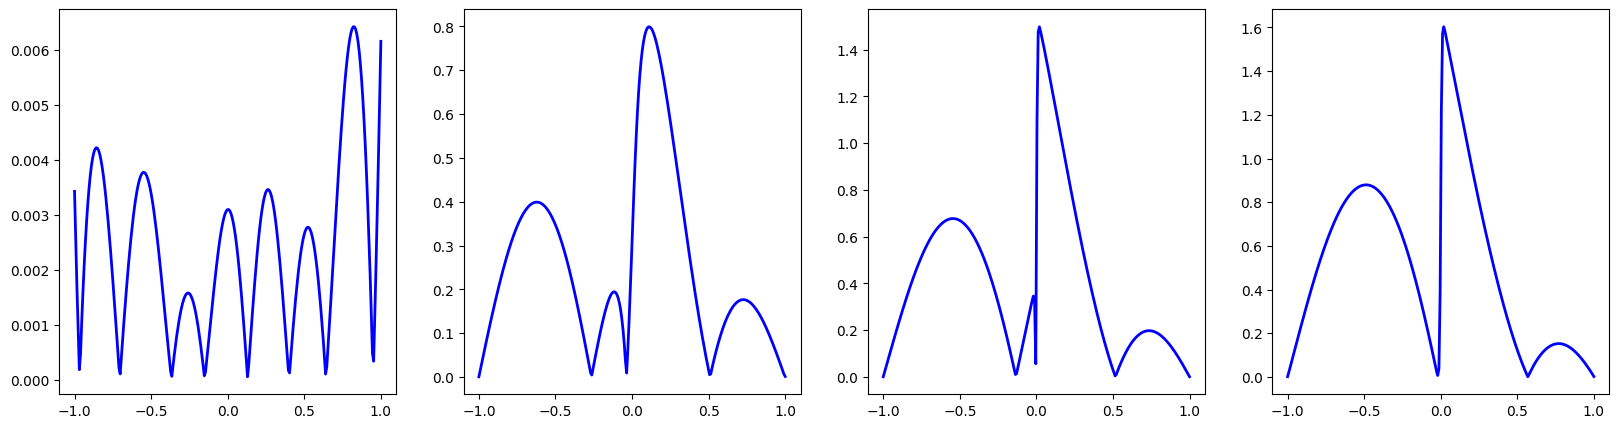

In [48]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

# Conclusion
Because we have less information about the system, this method leads to worst predictions than the PINNs


# Exercice 2: physical parameter identification with PINNs

Remind that Burgers equation are driven by the following PDE :

$$\frac{\partial u(x,t)}{\partial t} + a  ~ u(x,t) ~ \frac{\partial
u(x,t)}{\partial x} - \nu  ~ \frac{\partial^2 u(x,t)}{\partial x^2} =0$$

In the previous part, we supposed that $a$ and $\nu$ were known. In this
exercice,


**We will augment the PhysicsInformedNN to estimate the physical parameters
$\nu$ and $a$**


## 2.1) Write the code for getting training data

We randomly sample $N_u=500$ points on the (x,t) plane on which we will apply
*both* the labeled $l_u$ and unlabeled $l_f$ losses. Note that contrary to the
previous exercise, we don't sample on the boundary.


In [49]:
# Identification de paramètres physiques
np.random.seed(1234)
N_u = 500  # Number of points to compute the prediction loss (MSE_u)


# À compléter...
x_train_uf = torch.zeros(N_u)
t_train_uf = torch.zeros(N_u)
u_train_uf = torch.zeros(N_u)

index = torch.randint(x.size(0) * t.size(0), size=(N_u,))
ncols = t.size(0)
for i in range(N_u):
    idx_t = index[i] % ncols
    idx_x = index[i] // ncols
    x_train_uf[i] = x[idx_x]
    t_train_uf[i] = t[idx_t]
    u_train_uf[i] = Exact[idx_t, idx_x]

x_train_uf = x_train_uf.unsqueeze(-1).to(device)
t_train_uf = t_train_uf.unsqueeze(-1).to(device)
u_train_uf.to(device)

assert x_train_uf.shape == (N_u, 1), f"{x_train_uf.shape}"
assert t_train_uf.shape == (N_u, 1), f"{t_train_uf.shape}"
assert u_train_uf.shape == (N_u,), f"{u_train_uf.shape} vs {N_u}"

x_train_uf, t_train_uf, u_train_uf = prepare(x_train_uf, t_train_uf, u_train_uf)

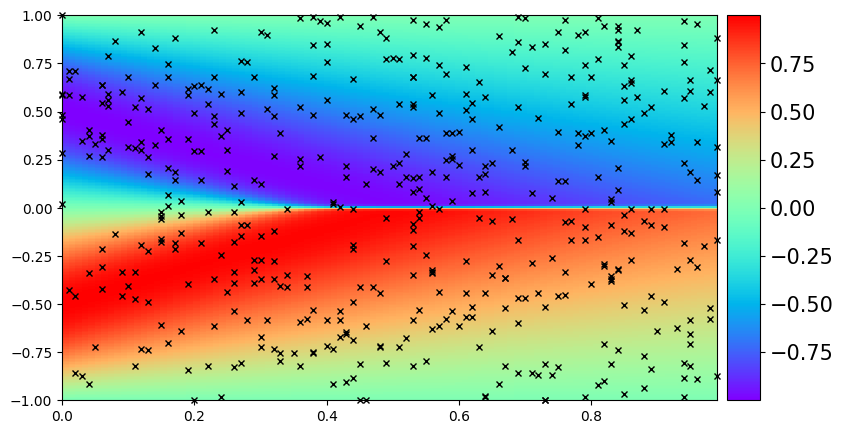

In [50]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=extent,
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train_uf.cpu().detach(),
    x_train_uf.cpu().detach(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

plt.show()

## 2.2) Create a new PhysicsInformedNN_ID with trainable parameters to estimate $\nu$ and $a$

In [72]:
# the physics-guided neural network


# À compléter...
class PhysicsInformedNN_ID(torch.nn.Module):
    def __init__(self, dnn: DNN):
        super().__init__()

        """
        We train nu and a using initial values nu = 0.01 / pi and a = 1
        """
        # self.nu = nn.Parameter(torch.tensor(0.01 / np.pi))

        # Using log to ensure positivity
        self.log_nu = nn.Parameter(torch.tensor(torch.randn(1)))

        self.a = nn.Parameter(torch.randn(1))
        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x.requires_grad_(True)
        t.requires_grad_(True)

        f_theta = self.dnn(x, t)

        nu = torch.exp(self.log_nu)

        df_dx = torch.autograd.grad(
            f_theta, x, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]
        df_dt = torch.autograd.grad(
            f_theta, t, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]
        df2_dx2 = torch.autograd.grad(
            df_dx, x, torch.ones_like(df_dx), retain_graph=True, create_graph=True
        )[0]

        h_res = df_dt + self.a * f_theta * df_dx - nu * df2_dx2
        return f_theta, h_res

    def get_a(self):
        return self.a

    def get_nu(self):
        return torch.exp(self.log_nu)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f

## 2.3) Train the model

In [87]:
# À compléter...
dnn = DNN()
dnn.to(device)
model = PhysicsInformedNN_ID(dnn)
model.to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-2)
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.2)

# print(optimizer.params)
epoch = 200
a_res = torch.zeros((epoch,))
nu_res = torch.zeros((epoch,))
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        u_pred, f_pred = model(x_train_uf, t_train_uf)
        loss, loss_u, loss_f = pinns_loss(
            u_pred, u_train_uf.unsqueeze(1), f_pred)
        # print(u_pred.shape, u_train_uf.shape, f_pred.shape)
        ti.set_description(
            f"loss: {loss}, nu: {float(model.get_nu())}, a: {float(model.get_a())}")

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)
    a_res[i] = model.get_a()
    nu_res[i] = model.get_nu()

/tmp/ipykernel_243585/4206143091.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_nu = nn.Parameter(torch.tensor(torch.randn(1)))
loss: 0.39943361282348633, nu: 1.0381613969802856, a: -1.2560958862304688:   0%|          | 0/200 [00:00<?, ?it/s]

loss: 0.0008715628064237535, nu: 0.002257528016343713, a: 0.9425840973854065: 100%|██████████| 200/200 [01:58<00:00,  1.68it/s] 


## 2.4) Evaluate prediction performances and physical parameter estimation quality

In [88]:
# PYSICAL PARAMETER IDENTIFICATION

# À compléter...
print(a_res, nu_res)

tensor([-1.2561, -1.2331, -0.9593, -0.5887,  0.4590,  0.6682,  0.4871,  0.2689,
         0.3355,  0.3826,  0.4046,  0.4572,  0.4659,  0.4590,  0.4862,  0.5223,
         0.5326,  0.5984,  0.6187,  0.6352,  0.6791,  0.7030,  0.7246,  0.8127,
         0.7937,  0.8030,  0.8116,  0.7990,  0.7765,  0.7868,  0.8053,  0.8192,
         0.8178,  0.8188,  0.8281,  0.8254,  0.8251,  0.8475,  0.8439,  0.8441,
         0.8619,  0.8629,  0.8612,  0.8660,  0.8631,  0.8741,  0.8803,  0.8834,
         0.8970,  0.9051,  0.8999,  0.8953,  0.9016,  0.9058,  0.9097,  0.9121,
         0.9146,  0.9158,  0.9165,  0.9220,  0.9254,  0.9255,  0.9200,  0.9176,
         0.9175,  0.9206,  0.9213,  0.9265,  0.9265,  0.9249,  0.9259,  0.9187,
         0.9162,  0.9167,  0.9168,  0.9160,  0.9165,  0.9157,  0.9169,  0.9153,
         0.9172,  0.9214,  0.9203,  0.9214,  0.9167,  0.9185,  0.9200,  0.9234,
         0.9227,  0.9247,  0.9283,  0.9285,  0.9303,  0.9324,  0.9333,  0.9352,
         0.9352,  0.9385,  0.9450,  0.94

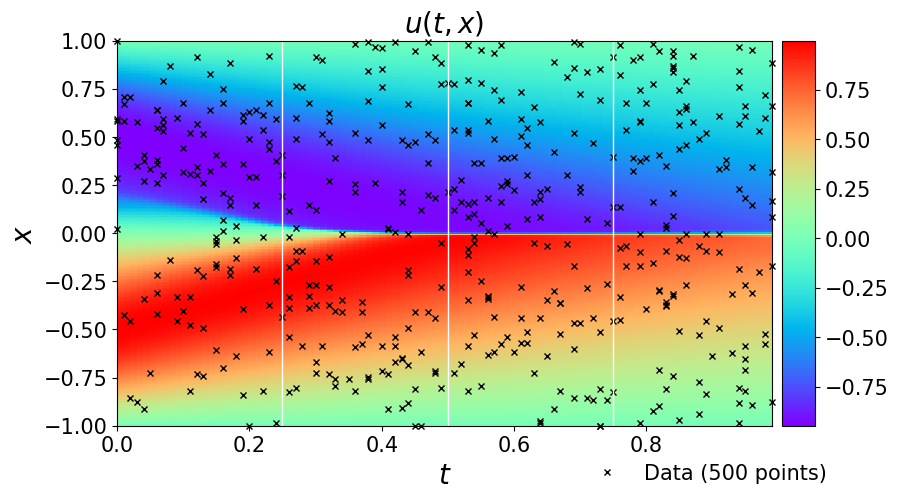

In [89]:
# Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train_uf.detach().cpu(),
    x_train_uf.detach().cpu(),
    "kx",
    label="Data (%d points)" % (u_train_uf.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 4.307316e-02
Error u: 4.303128e-02


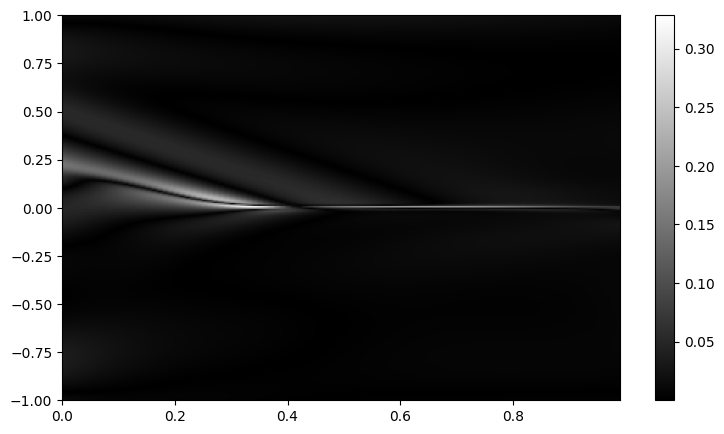

In [90]:
# FORECAST QUALITY
u_pred, f_pred = model.predict(x_star, t_star)
u_pred = u_pred.flatten()

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

U_pred = griddata(X_star, u_pred, (X, T), method="cubic")
Error = np.abs(Exact - U_pred)
error_u2 = np.linalg.norm(Exact - U_pred, "fro") / np.linalg.norm(U_pred, "fro")
print("Error u: %e" % (error_u2))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.cpu().T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

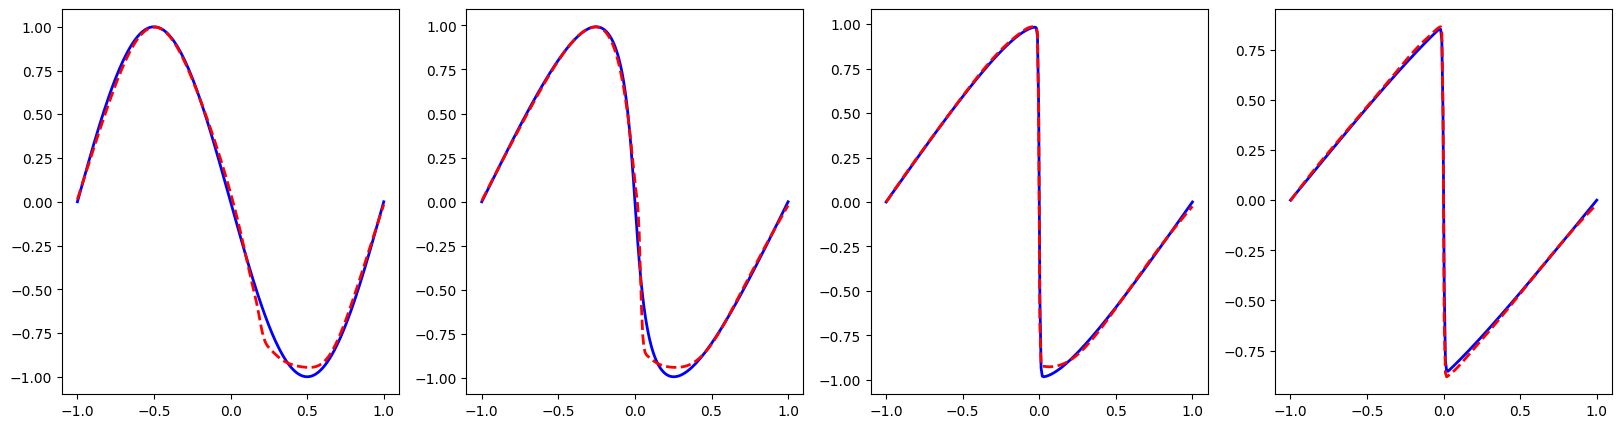

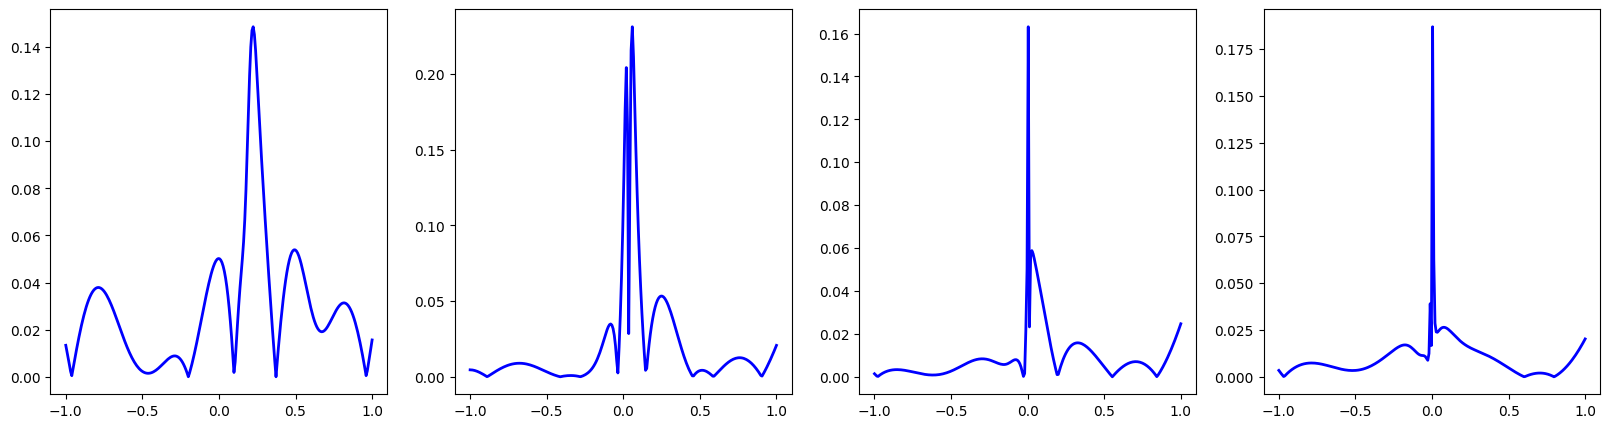

In [91]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

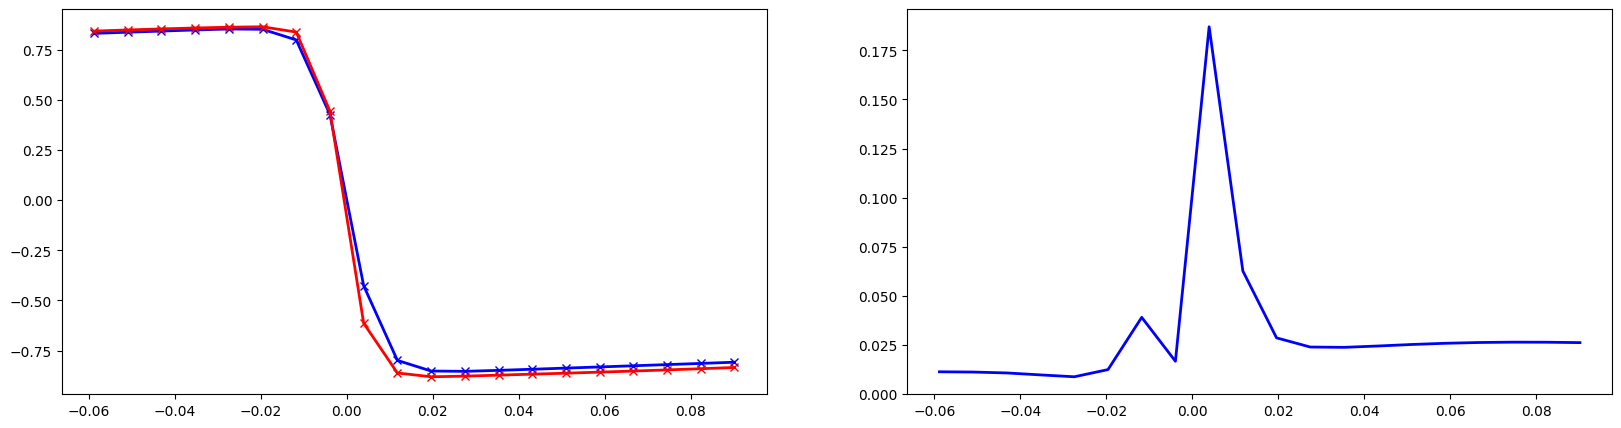

In [92]:
index = 75
min = 120
max = 140
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot(x[min:max], Exact[index, min:max], "b-x", linewidth=2, label="Exact")
ax.plot(x[min:max], U_pred[index, min:max], "r-x", linewidth=2, label="Prediction")

ax = fig.add_subplot(122)
ax.plot(x[min:max], Error[index, min:max], "b-", linewidth=2, label="Exact")

# Trying with KS equation : Kuramoto-Sivashinsky equation

The Kuramoto–Sivashinsky equation (KSE) is a fourth-order nonlinear partial differential equation that is used to describe the evolution of thin viscous fluid layers. It is named after Yoshiki Kuramoto and Grigori Isaakovich Sivashinsky.

$$\frac{\partial u(x,t)}{\partial t} + \frac{\partial^2 u(x,t)}{\partial x^2} + \frac{\partial^4 u(x,t)}{\partial x^4} + \nu~(\frac{\partial u(x,t)}{\partial x})^2 =0, \text{with } \nu= \frac{1}{2} $$ 

In [93]:
# Loading the data from the files

ks_t = torch.from_numpy(np.load("KS_t.npy"))
ks_x = torch.from_numpy(np.load("KS_x.npy"))
ks_u = torch.tensor(np.load("KS_u.npy"), dtype=torch.float32).T

# Keep only 1 every ds points (because of memory issues)
ds = 2
ks_t = ks_t[::ds]
# ks_x = ks_x[::ds]
ks_u = ks_u[::ds, :]

clip_idx = 0
ks_t = ks_t[clip_idx:]
ks_u = ks_u[clip_idx:, :]

print(f"ks_t: {ks_t.shape}, ks_x: {ks_x.shape}, ks_u: {ks_u.shape}")

ks_t: torch.Size([126]), ks_x: torch.Size([1024]), ks_u: torch.Size([126, 1024])


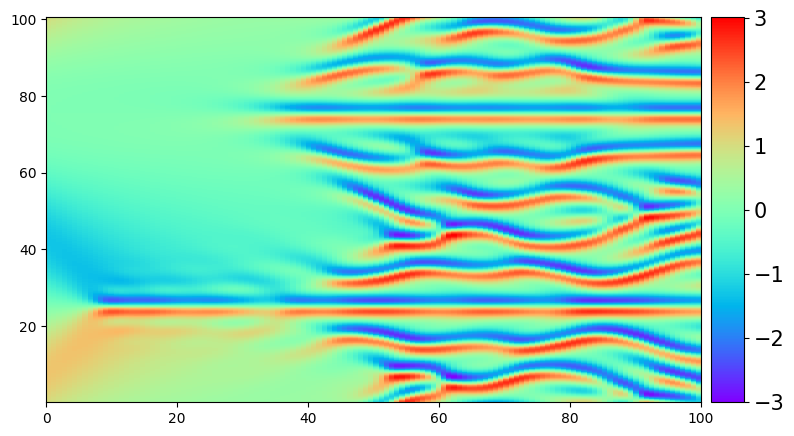

In [4]:
# Plotting the data

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    ks_u.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[ks_t.min(), ks_t.max(), ks_x.min(), ks_x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

plt.show()

In [5]:
# Creates a meshgrid from x and t, of shape (time x position)
T, X = torch.meshgrid(ks_t, ks_x)

assert len(X) == len(ks_t)
assert ks_u.shape == T.shape, f"{ks_u.shape} vs {T.shape}"

# Shape (N, 2)
X_star = torch.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))

# u(x,t) for X_star
u_star = torch.Tensor(ks_u.flatten())

print(f"X_star: {X_star.shape}")

X_star: torch.Size([129024, 2])


/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# Labeled points

N_u = 100  # Number of points to compute the prediction loss (MSE_u)

x_train = torch.zeros(N_u, 1)
t_train = torch.zeros(N_u, 1)
u_train = torch.zeros(N_u, 1)

print(u_train.shape)

available_t_xmin = torch.arange(ks_t.size(0) - 1)
available_t_xmax = torch.arange(ks_t.size(0) - 1)
available_x_t0 = torch.arange(ks_x.size(0) - 1)
choices = torch.linspace(start=0, end=2, steps=3, dtype=torch.int)

for i in range(N_u):
    choice = np.random.permutation(choices)[0]
    if choice == 0:
        # case (xmin,t)
        x_train[i] = ks_x[0]
        choice_t_xmin = np.random.choice(available_t_xmin)
        np.delete(available_t_xmin, choice_t_xmin)
        t_train[i] = ks_t[choice_t_xmin]
        u_train[i] = ks_u[choice_t_xmin, 0]
    elif choice == 1:
        x_train[i] = ks_x[-1]
        choice_t_xmax = np.random.choice(available_t_xmax)
        np.delete(available_t_xmax, choice_t_xmax)
        t_train[i] = ks_t[choice_t_xmax]
        u_train[i] = ks_u[choice_t_xmax, -1]
    else:
        # case (x,0)
        t_train[i] = ks_t[0]
        choice_x_t0 = np.random.choice(available_x_t0)
        np.delete(available_x_t0, choice_x_t0)
        x_train[i] = ks_x[choice_x_t0]
        u_train[i] = ks_u[0, choice_x_t0]


# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(ks_x.min())) | (x_train == float(ks_x.max()))
).all(), "Some points do not belong to boundary"

torch.Size([100, 1])


In [7]:
# Unlabeled points

N_f = 10000  # Number of points to apply the constraint

t_idx = torch.arange(ks_t.size(0) - 1)
x_idx = torch.arange(ks_x.size(0) - 1)
x_train_f = ks_x[np.random.choice(x_idx, N_f)].unsqueeze(-1)
t_train_f = ks_t[np.random.choice(t_idx, N_f)].unsqueeze(-1)

# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= ks_x.min()) & (x_train_f <= ks_x.max())).all()
assert ((t_train_f >= ks_t.min()) & (t_train_f <= ks_t.max())).all()

# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

In [8]:
# Let's move everything to the target device


def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

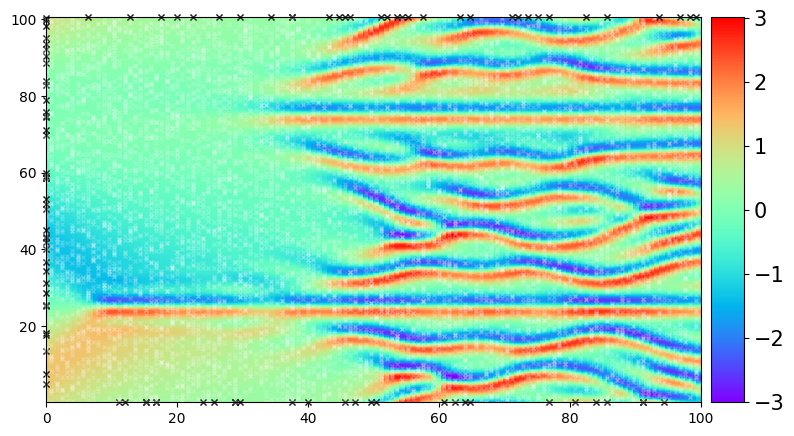

In [9]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    ks_u.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[ks_t.min(), ks_t.max(), ks_x.min(), ks_x.max()],
    origin="lower",
    aspect="auto",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=3,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

In [10]:
class DNN(torch.nn.Module):
    # À compléter...
    def __init__(self, depth=8, input_size=2, hidden_size=20, output_size=1):
        """
        input of size N_u x 2  = N_u x (x,t) dimensions
        """
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        layers = [("input", nn.Linear(input_size, hidden_size))]

        layers.append(("activation input", nn.Tanh()))
        for i in range(depth):
            layers.append(("hidden %d" % i, nn.Linear(hidden_size, hidden_size)))
            layers.append(("activation %d" % i, nn.Tanh()))
        layers.append(("output", nn.Linear(hidden_size, output_size)))

        dictLayers = OrderedDict(layers)
        self.seq = nn.Sequential(dictLayers)

    def forward(self, x, t):
        X_u_train = torch.cat((x, t), dim=-1)
        return self.seq(X_u_train)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u


dnn = DNN()


dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [11]:
print(dnn)

DNN(
  (seq): Sequential(
    (input): Linear(in_features=2, out_features=20, bias=True)
    (activation input): Tanh()
    (hidden 0): Linear(in_features=20, out_features=20, bias=True)
    (activation 0): Tanh()
    (hidden 1): Linear(in_features=20, out_features=20, bias=True)
    (activation 1): Tanh()
    (hidden 2): Linear(in_features=20, out_features=20, bias=True)
    (activation 2): Tanh()
    (hidden 3): Linear(in_features=20, out_features=20, bias=True)
    (activation 3): Tanh()
    (hidden 4): Linear(in_features=20, out_features=20, bias=True)
    (activation 4): Tanh()
    (hidden 5): Linear(in_features=20, out_features=20, bias=True)
    (activation 5): Tanh()
    (hidden 6): Linear(in_features=20, out_features=20, bias=True)
    (activation 6): Tanh()
    (hidden 7): Linear(in_features=20, out_features=20, bias=True)
    (activation 7): Tanh()
    (output): Linear(in_features=20, out_features=1, bias=True)
  )
)


the equation we are going to solve is the following :

(with $f_\theta(x,t) = u(x,t)$ )

$$h(f_\theta(x,t)) = \frac{\partial f_\theta(x,t)}{\partial t} + ~\frac{\partial^2 f_\theta(x,t)}{\partial x^2} + \frac{\partial^4 f_\theta(x,t)}{\partial x^4} + \frac{1}{2}( \frac{\partial f_\theta(x,t)}{\partial x})^2$$


In [12]:
# the physics-guided neural network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, dnn: DNN, nu: float):
        super().__init__()

        # nu = viscosity
        self.nu = nu
        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x.requires_grad_(True)
        t.requires_grad_(True)

        f_theta = self.dnn(x, t)

        df_dt = torch.autograd.grad(
            f_theta, t, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]

        df_dx = torch.autograd.grad(
            f_theta, x, torch.ones_like(f_theta), retain_graph=True, create_graph=True
        )[0]

        df2_dx2 = torch.autograd.grad(
            df_dx, x, torch.ones_like(df_dx), retain_graph=True, create_graph=True
        )[0]

        df3_dx3 = torch.autograd.grad(
            df2_dx2, x, torch.ones_like(df2_dx2), retain_graph=True, create_graph=True
        )[
            0
        ]  # Not needed (only used to calculate df4_dx4)

        df4_dx4 = torch.autograd.grad(
            df3_dx3, x, torch.ones_like(df3_dx3), retain_graph=True, create_graph=True
        )[0]

        h_res = df_dt + df2_dx2 + df4_dx4 + self.nu * (df_dx**2)
        return f_theta, h_res

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


model = PhysicsInformedNN(dnn, 0.01 / np.pi).to(device)

u, f = model(x_train[:5], t_train[:5])
assert u.shape == (5, 1) and f.shape == (5, 1)

In [13]:
import torch.nn.functional as F


def pinns_loss(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    f_pred: torch.Tensor,
    lambda_u=1.0,
    lambda_f=1.0,
):
    loss_u = F.mse_loss(u_pred, u_target)

    f_target = torch.zeros(f_pred.shape).to(device)
    loss_f = F.mse_loss(f_pred, f_target)

    loss = lambda_u * loss_u + lambda_f * loss_f

    return loss, loss_u, loss_f

In [14]:
from tqdm import tqdm

nu = 1 / 2

dnn = DNN()
dnn.to(device)
model = PhysicsInformedNN(dnn, nu)
model.to(device)
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.05)

epoch = 70
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        u_pred = dnn(x_train, t_train)

        f_theta, f_pred = model(x_train_f, t_train_f)
        loss, loss_u, loss_f = pinns_loss(u_pred, u_train, f_pred)
        ti.set_description(f"loss: {loss}")

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)

2024-01-26 11:34:52.619612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 11:34:52.773279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 11:34:55.103769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Infos/bd/client11/instantclient_11_2:/Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64:/Infos/bd/client11/instantclient_11_2:/Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64::/usr/local/

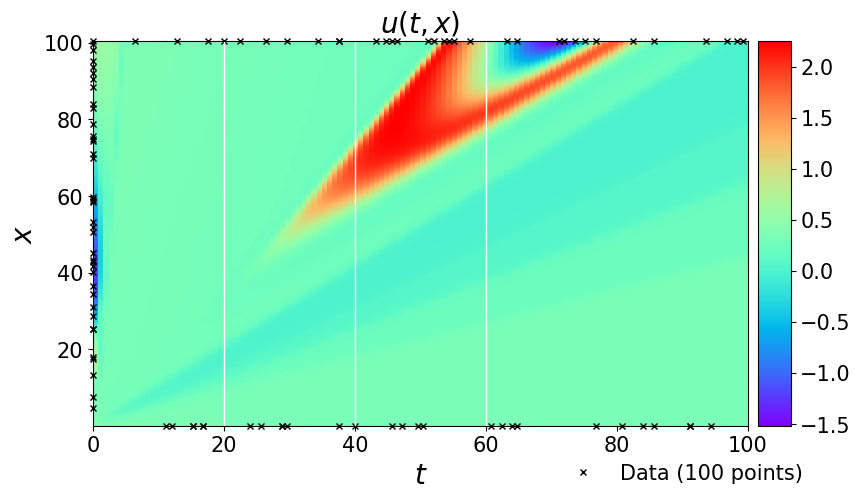

In [15]:
# Assessing the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[ks_t.min(), ks_t.max(), ks_x.min(), ks_x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(ks_x.min(), ks_x.max(), 2)[:, None]
ax.plot(ks_t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(ks_t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(ks_t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 1.722964e+00


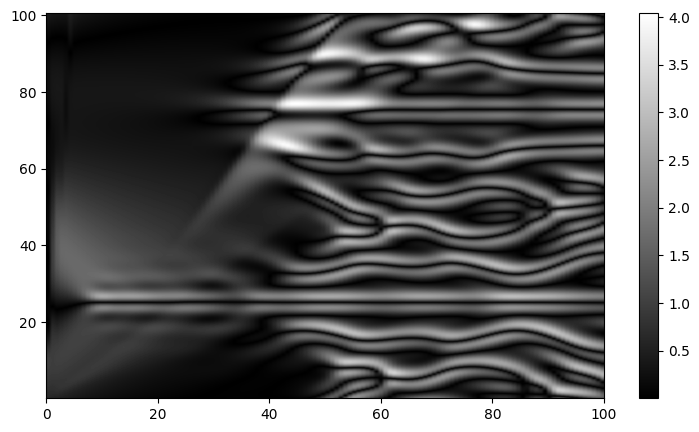

In [16]:
# Compute the mean prediction error
error_u = np.linalg.norm(ks_u.flatten() - u_pred.flatten(), 2) / np.linalg.norm(ks_u, 2)
print("Error u: %e" % (error_u))

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(ks_u - U_pred)

# Error in the $(x,t)$ planefig = plt.figure(figsize=(9, 5))
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[ks_t.min(), ks_t.max(), ks_x.min(), ks_x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

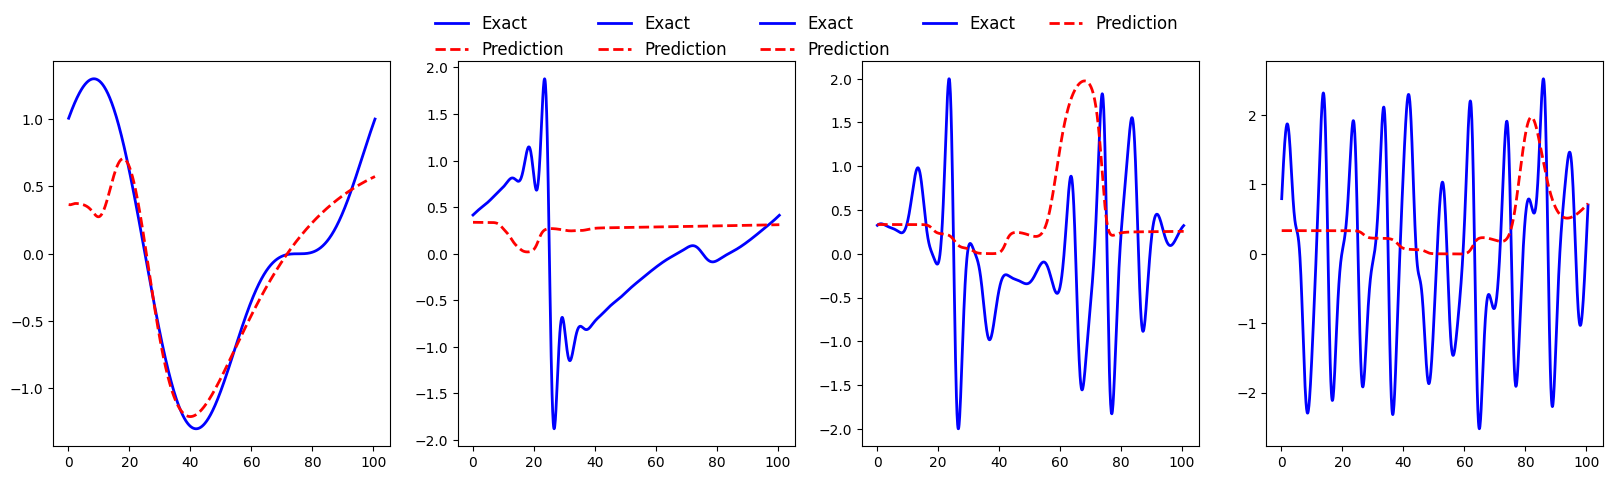

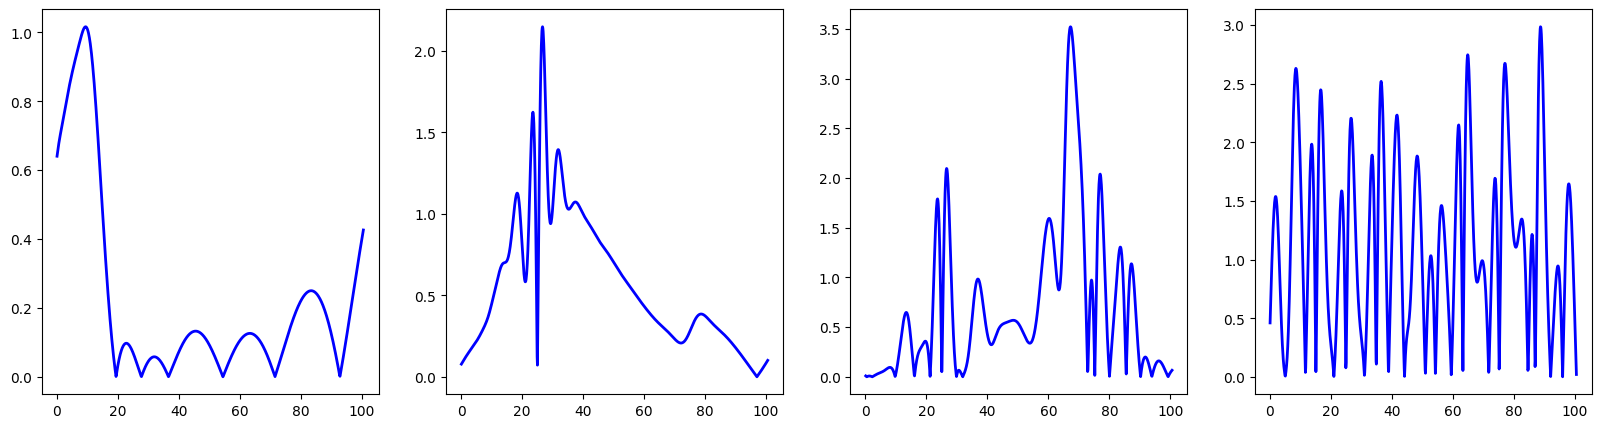

In [17]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(ks_x, ks_u[0, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(ks_x, ks_u[25, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(ks_x, ks_u[50, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[50, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(144)
ax.plot(ks_x, ks_u[75, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig.legend(loc="upper center", ncol=5, frameon=False, prop={"size": 12})

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(ks_x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(ks_x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(ks_x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(ks_x, Error[75, :], "b-", linewidth=2, label="Erreur")

# Now training without adding any constraint (fully data-driven model)

In [19]:
nu = 1 / 2

model = DNN()
model.to(device)
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=0.1)

epochs = 500
ti = tqdm(range(epochs))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        u_pred = model(x_train, t_train)
        loss = F.mse_loss(u_pred, u_train)
        ti.set_description(f"loss: {loss}")

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)

loss: 0.6619160175323486: 100%|██████████| 500/500 [00:51<00:00,  9.73it/s] 


Error u: 3.672783e+02


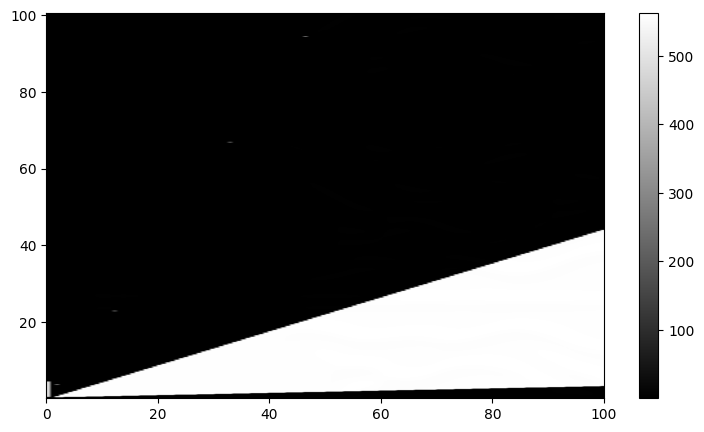

In [20]:
# Compute the mean prediction error
u_pred = model.predict(x_star, t_star)

error_u = np.linalg.norm(ks_u.flatten() - u_pred.flatten(), 2) / np.linalg.norm(ks_u, 2)
print("Error u: %e" % (error_u))

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")
Error = np.abs(ks_u - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[ks_t.min(), ks_t.max(), ks_x.min(), ks_x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

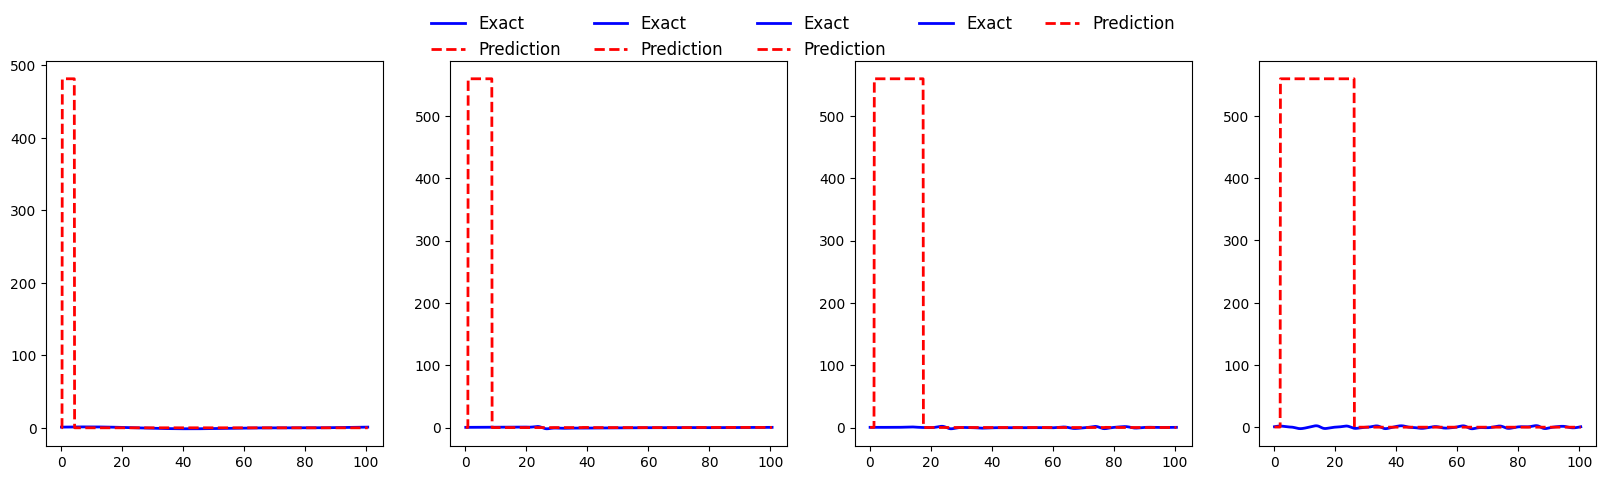

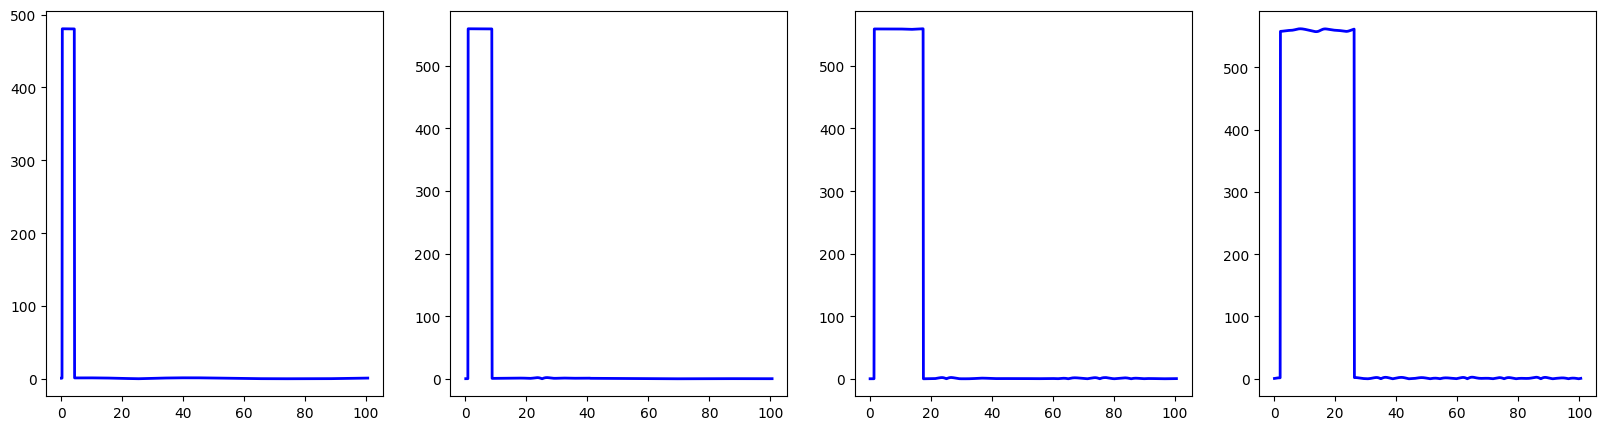

In [22]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(ks_x, ks_u[0, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(ks_x, ks_u[25, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(ks_x, ks_u[50, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[50, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(144)
ax.plot(ks_x, ks_u[75, :], "b-", linewidth=2, label="Exact")
ax.plot(ks_x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig.legend(loc="upper center", ncol=5, frameon=False, prop={"size": 12})

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(ks_x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(ks_x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(ks_x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(ks_x, Error[75, :], "b-", linewidth=2, label="Erreur")